<a href="https://colab.research.google.com/github/gguedes00/desafio_recomendacao/blob/main/desafio_recomenda%C3%A7ao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download de watch concluído!
Download de shoe concluído!
Download de shirt concluído!
Erro em /content/simple_images/watch/watch_4.jpg: cannot identify image file '/content/simple_images/watch/watch_4.jpg'
Erro em /content/simple_images/watch/watch_5.jpg: cannot identify image file '/content/simple_images/watch/watch_5.jpg'
Erro em /content/simple_images/shirt/shirt_3.jpg: cannot identify image file '/content/simple_images/shirt/shirt_3.jpg'


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Erro em /content/simple_images/shirt/shirt_2.jpg: cannot identify image file '/content/simple_images/shirt/shirt_2.jpg'
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Saving relogio.jpg to relogio.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


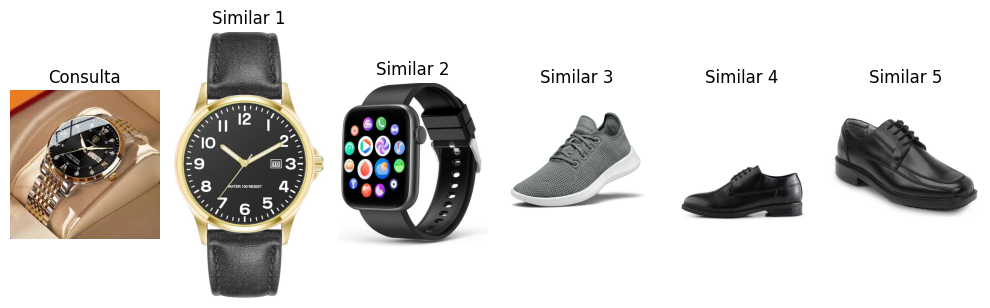

In [17]:
# %% [Instalação de Dependências]
!pip install simple_image_download

# %% [Importações]
import os
import numpy as np
from simple_image_download import simple_image_download as simp
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image

# %% [Download de Imagens da Web]
try:
    response = simp.simple_image_download()
    keywords = ["watch", "shoe", "shirt"]

    # Limpar pasta de downloads anteriores
    if os.path.exists("/content/simple_images"):
        !rm -rf /content/simple_images

    # Fazer download
    for keyword in keywords:
        response.download(keywords=keyword, limit=5)
        print(f"Download de {keyword} concluído!")

    dataset_folder = "/content/simple_images"
    use_custom_dataset = True

except Exception as e:
    print(f"Erro no download: {e}. Usando Fashion-MNIST...")
    use_custom_dataset = False

# %% [Carregar Modelo VGG16]
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# %% [Processamento das Imagens]
def process_image(img_path):
    try:
        img = Image.open(img_path).convert('RGB')  # Forçar conversão para RGB
        img = img.resize((224, 224))
        img_array = image.img_to_array(img)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Erro em {img_path}: {str(e)}")
        return None

if use_custom_dataset:
    # Processar imagens baixadas
    image_paths = []
    for root, _, files in os.walk(dataset_folder):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                image_paths.append(os.path.join(root, file))

    # Filtrar imagens válidas
    valid_images = []
    valid_paths = []
    for path in image_paths:
        processed = process_image(path)
        if processed is not None:
            valid_images.append(processed)
            valid_paths.append(path)

    # Gerar embeddings
    if valid_images:
        valid_images = np.array(valid_images)
        dataset_embeddings = model.predict(valid_images)
        dataset_embeddings = dataset_embeddings.reshape(len(valid_images), -1)
        dataset_images = valid_paths
    else:
        print("Nenhuma imagem válida encontrada! Usando Fashion-MNIST...")
        use_custom_dataset = False

if not use_custom_dataset:
    # Carregar Fashion-MNIST como fallback
    from tensorflow.keras.datasets import fashion_mnist
    (train_images, _), (_, _) = fashion_mnist.load_data()

    # Converter para formato compatível com VGG16
    train_images = np.array([np.stack([img]*3, axis=-1) for img in train_images])  # RGB
    train_images = np.array([image.smart_resize(img, (224, 224)) for img in train_images])
    train_images = preprocess_input(train_images)

    # Gerar embeddings
    dataset_embeddings = model.predict(train_images)
    dataset_embeddings = dataset_embeddings.reshape(len(train_images), -1)
    dataset_images = train_images

# %% [Upload da Imagem de Consulta]
from google.colab import files

uploaded = files.upload()
query_path = list(uploaded.keys())[0]
query_img = process_image(query_path)

# %% [Cálculo de Similaridade]
if query_img is not None:
    query_embedding = model.predict(np.expand_dims(query_img, axis=0))
    query_embedding = query_embedding.reshape(1, -1)

    similarities = cosine_similarity(query_embedding, dataset_embeddings)[0]
    similar_indices = np.argsort(similarities)[::-1][:5]

    # Exibir resultados
    plt.figure(figsize=(10, 5))

    # Imagem de consulta
    plt.subplot(1, 6, 1)
    if use_custom_dataset:
        plt.imshow(Image.open(query_path))
    else:
        plt.imshow(query_img.astype('uint8'))
    plt.title("Consulta")
    plt.axis('off')

    # Imagens recomendadas
    for i, idx in enumerate(similar_indices):
        plt.subplot(1, 6, i+2)
        if use_custom_dataset:
            plt.imshow(Image.open(dataset_images[idx]))
        else:
            plt.imshow(dataset_images[idx].astype('uint8'))
        plt.title(f"Similar {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Erro: Imagem de consulta inválida!")